In [14]:
import numpy, scipy.stats, pylab
try:
    import seabornss
except ImportError:
    pass
%matplotlib inline

We're trying to understand the relationship between sample size and testing for significance with binary samples.  The setup is that we have $N$ samples, we test them and get binary labels, and then we want to know if the breakdown of those labels is significantly different from $1:1$.  In the genetic case, the samples are individuals and the labels are the genotypes at some locus (from parent $A$ or parent $B$).  The null hypothesis is that the parent of origin doesn't matter, and so the genotypes are equally likely to be from $A$ or $B$.

We can do a binomial test (https://en.wikipedia.org/wiki/Binomial_test) for any pair of counts with the null hypothesis of $p=0.5$, for example:


In [41]:
print scipy.stats.binom_test(16, n=20, p=0.5)
print 2.0 * (1.0 - scipy.stats.binom.cdf(16-1, 20, 0.5)) # convert to two-sided test to match

0.0118179321289
0.0118179321289


So we'll be doing the test of the allele frequencies for many sites across the genome.  The one catch is that since we're doing so many tests at once, we need to have a more stringent cutoff for significance than the traditional $\alpha=0.05$ level.  A popular correction is the Bonferroni method, but here we don't exactly know how many independent tests we're doing (since nearby sites are correlated due to linkage).   Just to have a number, we can estimate/assume that each 10kb block is an independent test, and there are approximately 12M/10K $\approx$ 1000 such blocks.  Therefore we'll use $\alpha=0.05/1000=0.00005$ as a quick-and-dirty target threshold.

Now we can plot the p-values attained for various sample sizes:

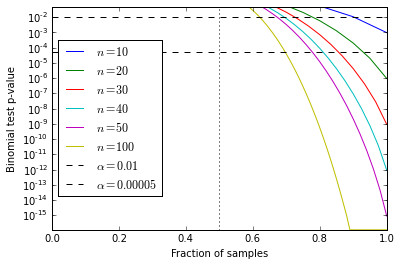

In [32]:
for N in [10, 20, 30, 40, 50, 100]:
    pylab.semilogy(1.0 * numpy.arange(N+1)/N, 1.0 - scipy.stats.binom.cdf(numpy.arange(N+1) - 1, N, 0.5), label = "$n=%d$" % N)

pylab.axvline(0.5, color="k", ls=":")
pylab.axhline(0.01, color="k", ls="--", label="$\\alpha=0.01$")
pylab.axhline(0.00005, color="k", ls="--", label="$\\alpha=0.00005$")
pylab.legend(loc="center left")
pylab.xlabel("Fraction of samples")
pylab.ylabel("Binomial test p-value")

pylab.axis([0, 1, 0, 0.05])
pylab.show()

The way to use this chart is, for a given sample size, to look up the fraction of samples with the majority allele ($x$ axis).  The colored lines show the p-value that breakdown will obtain (on the $y$ axis), for a range of sample sizes.  A horizontal line at a specific $y$ axis value (p-value threshold) gives the minimum sample fractions that would be deemed significant at a given sample size.  So for example, for the stringent cutoff of $\alpha=0.00005$, 100 samples would yield a significant hit for a 70/30% allele frequency split.  With 50 samples, that significance would only be attained with an 80/20% split, and it would never be attained for 10 samples.

The key unknown factor here is the target fraction you think you'll achieve.  This is related to how strict your selection criteria are or how clean your phenotype is.  The plots back up the intuition that the stronger this is (i.e., the closer to 100% one allele you get), the better off you are.

# A more formal way with R

We can do a more formal and explicit power analysis using the R package "pwr".  The idea is to specify a p-value threshold, a required probability of getting the correct result in your experiment (the power), and a sample size.  The method then tells you the required effect size (here, the difference in proportions) to achieve that.

See also:
- http://cran.r-project.org/web/packages/pwr/pwr.pdf
- https://en.wikipedia.org/wiki/Effect_size#Cohen.27s_h
- https://en.wikipedia.org/?title=Statistical_power

It's complicated by the fact that the effect size is measured in strange (to me) units (Cohen's $h$).

In [78]:
import pandas
import rpy2.robjects.packages
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
utils = importr("utils")
# utils.install_packages("pwr") # needed to install package
robjects.packages.importr("pwr")

rpy2.robjecs.packages.Package as a <module 'pwr' (built-in)>

In [96]:
def cohens_h(p1, p2):
    return 2.0 * (numpy.arcsin(p1**0.5) - numpy.arcsin(p2**0.5))

def inverse_h(h):
    return numpy.sin(h / 2.0 + numpy.arcsin(0.5**0.5))**2.0

In [149]:
print cohens_h(0.9, 0.5)
print cohens_h(0.5, 0.9)
print inverse_h(0.92729)

0.927295218002
-0.927295218002
0.899998434594


In [150]:
# power_calc = robjects.r["pwr.p.test"](sig_level=0.05, power=0.8, alt="greater", n=10)
# inverse_h(list(power_calc[power_calc.names.index("h")])[0])

In [153]:
df = {}
for N in [10, 20, 30, 40, 50, 100]:
    #  row = "$n=%d$" % N
    row = N
    df[row] = {}
    for alpha in [0.01, 0.00005]:
        power_calc = robjects.r["pwr.p.test"](sig_level=alpha, power=0.9, alt="greater", n=N)
        frac = inverse_h(list(power_calc[power_calc.names.index("h")])[0])
        df[row]["$\\alpha=%.5f$" % alpha] = frac
        
df = pandas.DataFrame(df).transpose()
df.index.name = "$n=$"
df

,$\alpha=0.00005$,$\alpha=0.01000$
$n=$,,
10,0.998952,0.954508
20,0.957707,0.861014
30,0.905044,0.806053
40,0.864826,0.770006
50,0.833969,0.744191
100,0.747234,0.676502


The above table gives the majority allele frequencies for achieving a certain p-value threshold (column labels) for a given sample size (row labels).  They mostly match the plot given above, which calculates a similar thing.  This analysis lets you control the statistical power explicitly, though.